In [36]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, matthews_corrcoef

In [37]:
data = pd.read_csv('ACI-IoT-2023.csv', nrows=100000)
list(data.columns.values)

['Flow_ID',
 'Src_IP',
 'Src_Port',
 'Dst_IP',
 'Dst_Port',
 'Protocol',
 'Timestamp',
 'Flow_Duration',
 'Total_Fwd_Packet',
 'Total_Bwd_packets',
 'Total_Length_of_Fwd_Packet',
 'Total_Length_of_Bwd_Packet',
 'Fwd_Packet_Length_Max',
 'Fwd_Packet_Length_Min',
 'Fwd_Packet_Length_Mean',
 'Fwd_Packet_Length_Std',
 'Bwd_Packet_Length_Max',
 'Bwd_Packet_Length_Min',
 'Bwd_Packet_Length_Mean',
 'Bwd_Packet_Length_Std',
 'Flow_Byts/s',
 'Flow_Pkts/s',
 'Flow_IAT_Mean',
 'Flow_IAT_Std',
 'Flow_IAT_Max',
 'Flow_IAT_Min',
 'Fwd_IAT_Total',
 'Fwd_IAT_Mean',
 'Fwd_IAT_Std',
 'Fwd_IAT_Max',
 'Fwd_IAT_Min',
 'Bwd_IAT_Total',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Max',
 'Bwd_IAT_Min',
 'Fwd_PSH_Flags',
 'Bwd_PSH_Flags',
 'Fwd_URG_Flags',
 'Bwd_URG_Flags',
 'Fwd_Header_Length',
 'Bwd_Header_Length',
 'Fwd_Packets/s',
 'Bwd_Packets/s',
 'Packet_Length_Min',
 'Packet_Length_Max',
 'Packet_Length_Mean',
 'Packet_Length_Std',
 'Packet_Length_Variance',
 'FIN_Flag_Count',
 'SYN_Flag_Count',
 'RST_F

In [38]:
data['Src_IP'] = data.Src_IP.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['Src_IP'] = data.Src_IP.apply(str)
data['Src_Port'] = data.Src_Port.apply(str)
data['Dst_IP'] = data.Dst_IP.apply(str)
data['Dst_Port'] = data.Dst_Port.apply(str)
data['Src_IP'] = data['Src_IP'] + ':' + data['Src_Port']
data['Dst_IP'] = data['Dst_IP'] + ':' + data['Dst_Port']
data.drop(columns=['Src_Port','Dst_Port','Timestamp', 'Flow_ID', 'Flow_Byts/s', 'Flow_Pkts/s',
                   'Connection_Type', ],inplace=True)
le = LabelEncoder()
le.fit_transform(data.Label.values)
data['Label'] = le.transform(data['Label'])
label = data.Label
data.drop(columns=['Label'],inplace = True)
scaler = StandardScaler()

In [39]:
data =  pd.concat([data, label], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)
encoder = ce.TargetEncoder(cols=['Fwd_PSH_Flags','Bwd_PSH_Flags','Protocol'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['Label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
X_train['h'] = X_train[ cols_to_norm ].values.tolist()
G = nx.from_pandas_edgelist(X_train, "Src_IP", "Dst_IP", ['h','Label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G,edge_attrs=['h','Label'] )
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
G.edata['train_mask']
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [40]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']

In [41]:
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [42]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [43]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [44]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [45]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight('balanced',
                                                 np.unique(G.edata['Label'].cpu().numpy())

                                                 )
class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [46]:
G.ndata['h'].device
G.edata['h'].device

node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['Label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)
opt = th.optim.Adam(model.parameters())

In [47]:
history = []
for epoch in range(1,50):
    pred = model(G, node_features,edge_features)
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    history.append(compute_accuracy(pred[train_mask], edge_label[train_mask]))
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

In [48]:
X_test = encoder.transform(X_test)
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

G_test = nx.from_pandas_edgelist(X_test, "Src_IP", "Dst_IP", ['h','Label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','Label'] )
actual = G_test.edata.pop('Label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))
G_test = G_test.to('cpu')

In [49]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test)
elapsed = timeit.default_timer() - start_time


test_pred = test_pred.argmax(1)

test_pred = th.Tensor.cpu(test_pred).detach().numpy()
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

Precision: 0.9998666849296305
Recall: 0.9998666666666667
F1-score: 0.9998665043574595
Accuracy: 0.9998666666666667


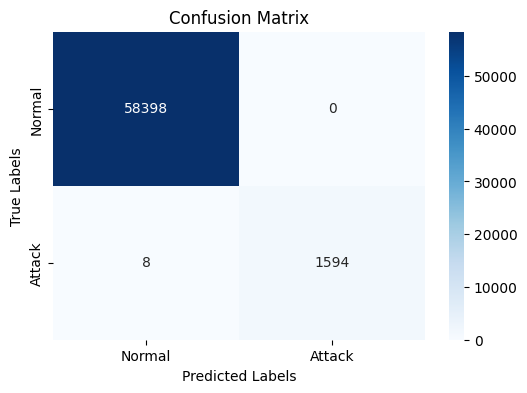

In [50]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
cnf_matrix = confusion_matrix(actual, test_pred)
precision,recall,fscore,none= precision_recall_fscore_support(actual, test_pred, average='weighted')
accuracy = accuracy_score(actual, test_pred)
print('Precision: '+(str(precision)))
print('Recall: '+(str(recall)))
print('F1-score: '+(str(fscore)))
print('Accuracy: '+(str(accuracy)))

plt.figure(figsize=(6, 4))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

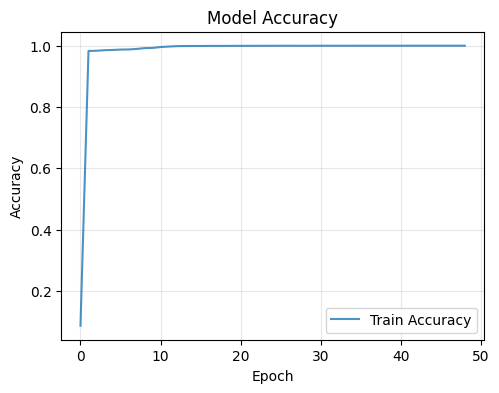

In [51]:
# Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history, label='Train Accuracy', alpha=0.8)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)